# Collaboration and Competition

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the third project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np
from tennis_agent import TennisAgent
from tennis_manager import TennisManager

import matplotlib.pyplot as plt
%matplotlib inline
is_ipython = 'inline' in plt.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Tennis.app"`
- **Windows** (x86): `"path/to/Tennis_Windows_x86/Tennis.exe"`
- **Windows** (x86_64): `"path/to/Tennis_Windows_x86_64/Tennis.exe"`
- **Linux** (x86): `"path/to/Tennis_Linux/Tennis.x86"`
- **Linux** (x86_64): `"path/to/Tennis_Linux/Tennis.x86_64"`
- **Linux** (x86, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86"`
- **Linux** (x86_64, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86_64"`

For instance, if you are using a Mac, then you downloaded `Tennis.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Tennis.app")
```

In [2]:
env = UnityEnvironment(file_name="Tennis.app")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, two agents control rackets to bounce a ball over a net. If an agent hits the ball over the net, it receives a reward of +0.1.  If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01.  Thus, the goal of each agent is to keep the ball in play.

The observation space consists of 8 variables corresponding to the position and velocity of the ball and racket. Two continuous actions are available, corresponding to movement toward (or away from) the net, and jumping. 

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agents and receive feedback from the environment.

Once this cell is executed, you will watch the agents' performance, if they select actions at random with each time step.  A window should pop up that allows you to observe the agents.

Of course, as part of the project, you'll have to change the code so that the agents are able to use their experiences to gradually choose better actions when interacting with the environment!

In [5]:
test_episodes = 5
# Temporatily disabled
test_episodes = 0

for i in range(test_episodes):                                      # play game for 5 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Score (max over agents) from episode {}: {}'.format(i, np.max(scores)))

When finished, you can close the environment.

In [6]:
# Temporarily disabled
# env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```

## 5. The Agents Before Training

We start by exposing our agents to the environment before triggering training, to see how they perform:

In [7]:
def start_rally(agents, environment, environment_params):
    
    brain_name = environment_params['brain_name']

    env_info = environment.reset(train_mode=False)[brain_name]     
    states = env_info.vector_observations                 
    scores = np.zeros(len(agents))                        
    while True:

        actions = [agent.act(states=states, action_parameters={'add_noise': False}) 
                   for agent in agents]
        
        env_info = environment.step(actions)[brain_name]           
        next_states = env_info.vector_observations       
        rewards = env_info.rewards                       
        dones = env_info.local_done
        
        scores += rewards                       
        states = next_states                              
        if np.any(dones):                                  
            break
    print('Scores for this episode: {}'.format(scores))

environment_params = {'brain_name': brain_name}

horna_and_cueva = [TennisAgent(index=index, num_agents=num_agents, state_size=state_size, action_size=action_size) 
                   for index in range(num_agents)]
print("Horna and Cueva are ready to play ...")

for _ in range(test_episodes):
    start_rally(agents=horna_and_cueva, environment=env, environment_params=environment_params)

Horna and Cueva are ready to play ...


## 6. They're not performing good

So some training is needed:

Starting training ...
Episode 100	Average Score: 0.00
Episode 100 Average score over the last 100  episodes:  0.003900000061839819
Episode 200	Average Score: 0.00
Episode 200 Average score over the last 100  episodes:  0.0
Episode 300	Average Score: 0.00
Episode 300 Average score over the last 100  episodes:  0.0029000000469386576
Episode 400	Average Score: 0.00
Episode 400 Average score over the last 100  episodes:  0.0019000000320374966
Episode 500	Average Score: 0.00
Episode 500 Average score over the last 100  episodes:  0.0010000000149011613
Episode 600	Average Score: 0.00
Episode 600 Average score over the last 100  episodes:  0.0018000000342726708
Episode 700	Average Score: 0.00
Episode 700 Average score over the last 100  episodes:  0.004000000059604645
Episode 800	Average Score: 0.00
Episode 800 Average score over the last 100  episodes:  0.0
Episode 900	Average Score: 0.00
Episode 900 Average score over the last 100  episodes:  0.0010000000149011613
Episode 1000	Average Score

Episode 8200	Average Score: 0.00
Episode 8200 Average score over the last 100  episodes:  0.0
Episode 8300	Average Score: 0.00
Episode 8300 Average score over the last 100  episodes:  0.0
Episode 8400	Average Score: 0.00
Episode 8400 Average score over the last 100  episodes:  0.0
Episode 8500	Average Score: 0.00
Episode 8500 Average score over the last 100  episodes:  0.0
Episode 8600	Average Score: 0.00
Episode 8600 Average score over the last 100  episodes:  0.0
Episode 8700	Average Score: 0.00
Episode 8700 Average score over the last 100  episodes:  0.0
Episode 8800	Average Score: 0.00
Episode 8800 Average score over the last 100  episodes:  0.0
Episode 8900	Average Score: 0.00
Episode 8900 Average score over the last 100  episodes:  0.0
Episode 9000	Average Score: 0.00
Episode 9000 Average score over the last 100  episodes:  0.0
Episode 9100	Average Score: 0.00
Episode 9100 Average score over the last 100  episodes:  0.0
Episode 9200	Average Score: 0.00
Episode 9200 Average score 

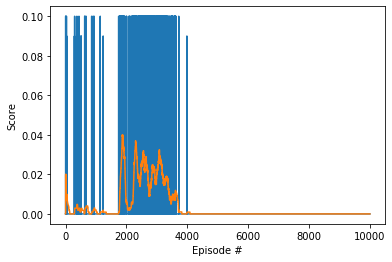

In [8]:
score_window = 100
num_episodes = 10000
network_file = "checkpoint.pth"
target_score = 0.5

tennis_manager = TennisManager(environment_params=environment_params)

scores, avg_scores = tennis_manager.start_training(agents=horna_and_cueva, environment=env,
                                      score_window=score_window,
                                      num_episodes=num_episodes,
                                      network_file=network_file,
                                      target_score=target_score)

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.plot(np.arange(len(avg_scores)), avg_scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()